# Evaluation du modèle

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from joblib import load

# Import des données: 
X_train = pd.read_csv("../data/preprocessed/X_train.csv")
y_train = pd.read_csv("../data/preprocessed/y_train.csv")
X_test = pd.read_csv("../data/preprocessed/X_test.csv")
y_test = pd.read_csv("../data/preprocessed/y_test.csv")

# Chargement du modèle:
rdf = load('../src/models/trained_model.joblib')

In [4]:
y_train.value_counts(normalize = True)
# 66% des accidents sont non prioritaires (catégorie blessés légers), 34% sont prioritaires (blessés hospitalisés, tués)

grav
0       0.659423
1       0.340577
Name: proportion, dtype: float64

In [5]:
y_test.value_counts(normalize = True)
# On retrouve la même proportion dans l'échantillon de test.

grav
0       0.654296
1       0.345704
Name: proportion, dtype: float64

Le modèle a été entrainé sans rééquilibrage. Source: `train_model.py`

In [6]:
from sklearn.metrics import classification_report, confusion_matrix
y_pred = rdf.predict(X_test)

print("Matrice de confusion:")
print(pd.crosstab(y_test.T.to_numpy(), y_pred, rownames=['Classe réelle'], colnames=['Classe prédite']))
print("----------------------------------")
print("Classification report:")
print(classification_report(y_test, y_pred))


Matrice de confusion:
Classe prédite     0     1
Classe réelle             
0               9370  1367
1               2313  3360
----------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.80      0.87      0.84     10737
           1       0.71      0.59      0.65      5673

    accuracy                           0.78     16410
   macro avg       0.76      0.73      0.74     16410
weighted avg       0.77      0.78      0.77     16410



**Constat**: La classe minoritaire (1: intervention prioritaire) est moins bien gérée que la classe majoritaire (0: intervention non prioritaire).  
**Suggestions:**   
1. Sans modifier le modèle: choisir `f1-score macro avg` comme métrique?
2. Modifier le modèle:
    - ré équilibrage via resampling en amont?
    - ré équilibrage via ROC en aval?

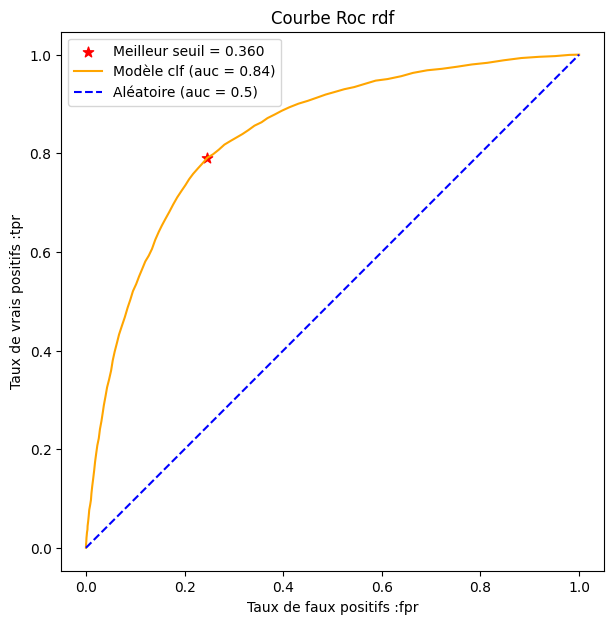

Rapport rdf: 
               precision    recall  f1-score   support

           0       0.87      0.76      0.81     10737
           1       0.64      0.78      0.70      5673

    accuracy                           0.77     16410
   macro avg       0.75      0.77      0.76     16410
weighted avg       0.79      0.77      0.77     16410

[[8205 2532]
 [1254 4419]]


In [13]:
from sklearn.metrics import roc_curve, auc

# Prediction sur test:
preds = rdf.predict_proba(X_test)

# Création des arrays fpr, tpr et seuils:
fpr, tpr, seuils = roc_curve(y_test, preds[:, 1], pos_label = 1) # on choisit pred[:, 1] pour prendre parmi les deux probas celle qui correspond à la classe positive.

# Calcul de l'aire sous la courbe ROC:
roc_auc = auc(x = fpr, y = tpr)

# Recherche du meilleur seuil:
dist = 1
for (x, y, s) in zip(fpr, tpr, seuils):
    dist1 = np.square(x**2 + (y-1)**2)
    if dist1 < dist:
        dist = dist1
        seuil_best = s 
        fpr_best = x
        tpr_best = y

# Tracé de la courbe ROC:
plt.figure(figsize = (7, 7))
plt.axis('equal')

plt.scatter(fpr_best, tpr_best, s = 60, c = 'red', marker = '*', alpha = 1, label = "Meilleur seuil = %0.3f" % seuil_best)
plt.plot(fpr, tpr, c = 'orange', label = 'Modèle clf (auc = %0.2f)' % roc_auc)
plt.plot(fpr, fpr, 'b--', label = 'Aléatoire (auc = 0.5)')

plt.title('Courbe Roc rdf')
plt.xlabel('Taux de faux positifs :fpr')
plt.ylabel('Taux de vrais positifs :tpr')
plt.legend()

plt.show()

# Analyse des résultats en appliquant le meilleur seuil:
y_pred = pd.Series(np.where(preds[:, 1] > seuil_best, 1, 0))

print("Rapport rdf:", "\n", classification_report(y_test, y_pred,  digits = 2))
print(confusion_matrix(y_test, y_pred))

**Conclusions:**  
* On arrive à un meilleur `f1-score macro avg` (76% vs 74 %)
* La précision de la classe prioritaire est moindre (64% vs 71%): il y aura 36% de fausses alertes, mais...
* ... le rappel de la classe prioritaire est bien meilleur (78 % vs 59%): on détecte **mieux** les cas prioritaires.
